# <center> The D-ACO/GA Project <br>
## <center> (Digital - Ant Colony Optimization/Genetic Algorithm)
### <center> Classification with Spark
#### <center> Dataset NBaIoT

In [1]:
import findspark
findspark.init()

In [2]:
# Importação de modulos Python
import os
import time
from datetime import datetime

import pandas as pd

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

import pyspark.pandas as ps
from pyspark.ml import feature

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
# Importação das bibliotecas Graficas
import scikitplot as skplt
import matplotlib.pyplot as plt

# Exibe gráficos na página (inline)
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Classificação e Avaliação - Apache Spark

In [6]:
spark = SparkSession.builder\
       .appName("D-ACO/IDS_SPARK")\
       .master("spark://192.168.1.20:7077") \
       .getOrCreate()

24/02/26 02:18:01 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Seleção e Apresentação do Dataset

In [ ]:
dfTrain = ps.read_csv('../../../../../datasets/dacoga/nbaiot/bestsub/NBaIoT60Train_ACO_2024_02_25_20_38_00_selected.csv')
dfTrain.head()

24/02/26 02:18:24 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/02/26 02:18:39 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/02/26 02:18:54 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/02/26 02:19:09 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources
24/02/26 02:19:24 WARN TaskSchedulerImpl: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


In [8]:
dfTest = ps.read_csv('../../../../../datasets/dacoga/nbaiot/test/dsetN-Baiot_v2_60_test.csv')
dfTest = dfTest[dfTrain.columns]
#dfTest.head()

In [9]:
# Listando as colunas
#dfTrain.columns

In [10]:
#dfTest.columns

In [11]:
# Start algorithms time
start_time = time.time()

In [12]:
dataframeTrain = dfTrain.to_spark()

In [13]:
vecAssembler = VectorAssembler(inputCols=dataframeTrain.columns[:-1], outputCol='features')

dsetTrain = vecAssembler.transform(dataframeTrain)
dsetTrain = dsetTrain.select("label","features")

#dfTrain.show(5, truncate=True)

In [14]:
mmScaler = feature.MinMaxScaler(inputCol='features', 
                                outputCol='scaled_features').fit(dsetTrain)

dsetTrain = mmScaler.transform(dsetTrain).drop('features')
dsetTrain = dsetTrain.withColumnRenamed('scaled_features', 'features')

#dfTrain.show(5, truncate=True)

In [15]:
dataframeTest = dfTest.to_spark()

In [16]:
vecAssembler = VectorAssembler(inputCols=dataframeTest.columns[:-1], outputCol='features')

dsetTest = vecAssembler.transform(dataframeTest)
dsetTest = dsetTest.select("label","features")

#dfTrain.show(5, truncate=True)

In [17]:
mmScaler = feature.MinMaxScaler(inputCol='features', 
                                outputCol='scaled_features').fit(dsetTest)

dsetTest = mmScaler.transform(dsetTest).drop('features')
dsetTest = dsetTest.withColumnRenamed('scaled_features', 'features')

#dfTrain.show(5, truncate=True)

In [18]:
# Split ramdomly the dataset into train and test group
# [0.7,0.3] => 70% for train and 30% for test
# [1.0,0.2] => 100% for train and 20% for test, not good, acuracy always 100%
# [0.1,0.02] => 10% for train and 2% for test, if big datasets
# 1234 is the random seed

# Sample of train and test dataset
train_sample = 0.7
test_sample = 0.3

# Split the data into training and test sets (30% held out for testing)
#(trainingData, testData) = df_spark.randomSplit([train_sample, test_sample], seed=1234)

trainingData = dsetTrain
testData = dsetTest

In [19]:
# Dicionário de resultados
dic = {}

### Treinando e avaliando com Árvore de Decisão

In [20]:
start_time_dt =  time.time()

# Train a DecisionTree model
clf_dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability', \
                            rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, \
                            maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None)

# Train model
model_dt = clf_dt.fit(trainingData)

# Make predictions.
pred_dt = model_dt.transform(testData)

In [21]:
# Compute accuracy on the test set against model and select (prediction, true label) and compute test error
eval_accuracy_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_precision_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
eval_recall_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
eval_f1_dt = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
eval_auc_dt = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

accuracy_dt = eval_accuracy_dt.evaluate(pred_dt) * 100
precision_dt = eval_precision_dt.evaluate(pred_dt) * 100
recall_dt = eval_recall_dt.evaluate(pred_dt) * 100
f1score_dt = eval_f1_dt.evaluate(pred_dt) * 100
auc_dt = eval_accuracy_dt.evaluate(pred_dt) * 100

dic['Árvore de\nDecisão']  = accuracy_dt
time_dt = time.time() - start_time_dt

print("============================================================")
print("========== Sumário da Avaliação Árvore de Decisão ==========")
print("Acurácia = %3.2f %%" % accuracy_dt)
print("Precisão = %3.2f %%" % precision_dt)
print("Recall = %3.2f %%" % recall_dt)
print("F1-Score = %3.2f %%" % f1score_dt)
print("Curva ROC = %3.2f %%" % auc_dt)
print("Tempo de Execução = %3.3f s" % time_dt)
print("============================================================")

========== Sumário da Avaliação Árvore de Decisão ==========
Acurácia = 99.93 %
Precisão = 99.95 %
Recall = 99.97 %
F1-Score = 99.93 %
Curva ROC = 99.93 %
Tempo de Execução = 58.889 s


In [22]:
# Agrupar por rótulos reais e previsões e contar o número de ocorrências
confusion_matrix_df = pred_dt.groupBy('label', 'prediction').count()

# Para visualizar a matriz de confusão como um DataFrame
confusion_matrix_df.show()

# Para uma melhor visualização e entendimento, você pode pivotar os dados
# Isso é útil especialmente se você tem um número fixo de classes e deseja uma matriz quadrada
confusion_matrix_pivot_dt = confusion_matrix_df.groupBy('label').pivot('prediction', [0, 1]).sum('count')\
                                            .fillna(0) # substitui os NAs por 0 para casos onde não há previsões para uma classe

confusion_matrix_pivot_dt.show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       1.0|153760|
|    0|       0.0|589878|
|    0|       1.0|   204|
|    1|       0.0|   305|
+-----+----------+------+



+-----+------+------+
|label|     0|     1|
+-----+------+------+
|    1|   305|153760|
|    0|589878|   204|
+-----+------+------+



In [23]:
# print("Decision Tree Final Result")
# predictions.show(5)

### Treinando e avaliando com Random Forest

In [24]:
start_time_rf =  time.time()

# Train a Random Forest model
clf_rf = RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability',\
                                 rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,\
                                 numTrees=50, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0,\
                                 maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini')

# Train model
model_rf = clf_rf.fit(trainingData)

# Make predictions.
pred_rf = model_rf.transform(testData)

In [25]:
# Compute accuracy on the test set against model and select (prediction, true label) and compute test error
eval_accuracy_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_precision_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
eval_recall_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
eval_f1_rf = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
eval_auc_rf = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

accuracy_rf = eval_accuracy_dt.evaluate(pred_rf) * 100
precision_rf = eval_precision_dt.evaluate(pred_rf) * 100
recall_rf = eval_recall_dt.evaluate(pred_rf) * 100
f1score_rf = eval_f1_dt.evaluate(pred_rf) * 100
auc_rf = eval_accuracy_dt.evaluate(pred_rf) * 100

dic['Random\nForest']  = accuracy_rf
time_rf = time.time() - start_time_rf

print("========================================================")
print("========== Sumário da Avaliação Random Forest ==========")
print("Acurácia = %3.2f %%" % accuracy_rf)
print("Precisão = %3.2f %%" % precision_rf)
print("Recall = %3.2f %%" % recall_rf)
print("F1-Score = %3.2f %%" % f1score_rf)
print("Curva ROC = %3.2f %%" % auc_rf)
print("Tempo de Execução = %3.3f s" % time_rf)
print("========================================================")

========== Sumário da Avaliação Random Forest ==========
Acurácia = 99.93 %
Precisão = 99.96 %
Recall = 99.95 %
F1-Score = 99.93 %
Curva ROC = 99.93 %
Tempo de Execução = 46.220 s


In [26]:
# Agrupar por rótulos reais e previsões e contar o número de ocorrências
confusion_matrix_rf = pred_rf.groupBy('label', 'prediction').count()

# Para visualizar a matriz de confusão como um DataFrame
confusion_matrix_rf.show()

# Para uma melhor visualização e entendimento, você pode pivotar os dados
# Isso é útil especialmente se você tem um número fixo de classes e deseja uma matriz quadrada
confusion_matrix_pivot_rf = confusion_matrix_rf.groupBy('label').pivot('prediction', [0, 1]).sum('count')\
                                            .fillna(0) # substitui os NAs por 0 para casos onde não há previsões para uma classe

confusion_matrix_pivot_rf.show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       1.0|153839|
|    0|       0.0|589776|
|    0|       1.0|   306|
|    1|       0.0|   226|
+-----+----------+------+



+-----+------+------+
|label|     0|     1|
+-----+------+------+
|    1|   226|153839|
|    0|589776|   306|
+-----+------+------+



### Treinando e avaliando com Naive Bayes

In [27]:
start_time_nb =  time.time()

clf_nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# Train model
model_nb = clf_nb.fit(trainingData)

# Make predictions.
pred_nb = model_nb.transform(testData)

In [28]:
# Compute accuracy on the test set against model and select (prediction, true label) and compute test error
eval_accuracy_nb = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_precision_nb = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
eval_recall_nb = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
eval_f1_nb = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
eval_auc_nb = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

accuracy_nb = eval_accuracy_dt.evaluate(pred_nb) * 100
precision_nb = eval_precision_dt.evaluate(pred_nb) * 100
recall_nb = eval_recall_dt.evaluate(pred_nb) * 100
f1score_nb = eval_f1_dt.evaluate(pred_nb) * 100
auc_nb = eval_accuracy_dt.evaluate(pred_nb) * 100

dic["Naive\nBayes"]  = accuracy_nb
time_nb = time.time() - start_time_nb

print("======================================================")
print("========== Sumário da Avaliação Naive Bayes ==========")
print("Acurácia = %3.2f %%" % accuracy_nb)
print("Precisão = %3.2f %%" % precision_nb)
print("Recall = %3.2f %%" % recall_nb)
print("F1-Score = %3.2f %%" % f1score_nb)
print("Curva ROC = %3.2f %%" % auc_nb)
print("Tempo de Execução = %3.3f s" % time_nb)
print("======================================================")

========== Sumário da Avaliação Naive Bayes ==========
Acurácia = 97.86 %
Precisão = 97.43 %
Recall = 99.94 %
F1-Score = 97.81 %
Curva ROC = 97.86 %
Tempo de Execução = 128.029 s


In [29]:
# Agrupar por rótulos reais e previsões e contar o número de ocorrências
confusion_matrix_nb = pred_nb.groupBy('label', 'prediction').count()

# Para visualizar a matriz de confusão como um DataFrame
confusion_matrix_nb.show()

# Para uma melhor visualização e entendimento, você pode pivotar os dados
# Isso é útil especialmente se você tem um número fixo de classes e deseja uma matriz quadrada
confusion_matrix_pivot_nb = confusion_matrix_rf.groupBy('label').pivot('prediction', [0, 1]).sum('count')\
                                            .fillna(0) # substitui os NAs por 0 para casos onde não há previsões para uma classe

confusion_matrix_pivot_nb.show()

+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|    1|       1.0|138491|
|    0|       0.0|589705|
|    0|       1.0|   377|
|    1|       0.0| 15574|
+-----+----------+------+



+-----+------+------+
|label|     0|     1|
+-----+------+------+
|    1|   226|153839|
|    0|589776|   306|
+-----+------+------+



### Treinando e avaliando com Suport Vector Machines (SVM)

In [30]:
start_time_svm =  time.time()

# create the trainer and set its parameters
clf_svm = LinearSVC(featuresCol='features', labelCol='label', maxIter=10, regParam=0.1)

# train the multiclass model.
model_svm = clf_svm.fit(trainingData)

# score the model on test data.
pred_svm = model_svm.transform(testData)

24/02/26 00:06:06 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [31]:
# Compute accuracy on the test set against model and select (prediction, true label) and compute test error
eval_accuracy_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_precision_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
eval_recall_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
eval_f1_svm = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
eval_auc_svm = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

accuracy_svm = eval_accuracy_svm.evaluate(pred_svm) * 100
precision_svm = eval_precision_svm.evaluate(pred_svm) * 100
recall_svm = eval_recall_svm.evaluate(pred_svm) * 100
f1score_svm = eval_f1_svm.evaluate(pred_svm) * 100
auc_svm = eval_accuracy_svm.evaluate(pred_svm) * 100

dic["SVM"]  = accuracy_svm
time_svm = time.time() - start_time_svm

print("==============================================")
print("========== Sumário da Avaliação SVM ==========")
print("Acurácia = %3.2f %%" % accuracy_svm)
print("Precisão = %3.2f %%" % precision_svm)
print("Recall = %3.2f %%" % recall_svm)
print("F1-Score = %3.2f %%" % f1score_svm)
print("Curva ROC = %3.2f %%" % auc_svm)
print("Tempo de Execução = %3.3f s" % time_svm)
print("==============================================")
# https://www.kaggle.com/code/shrutimechlearn/pyspark-part-3-classification-modelling-dtree
# https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine
# https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html

========== Sumário da Avaliação SVM ==========
Acurácia = 82.19 %
Precisão = 81.66 %
Recall = 100.00 %
F1-Score = 76.36 %
Curva ROC = 82.19 %
Tempo de Execução = 4189.802 s


In [32]:
print("================================================================================")
print("=========================  Compare Algorithm and Time ==========================")
print()
print("Técnicas               Acurácia  Precisão  Recall   F1-Score   ROC      Tempo")
print("Decision Tree:         %3.3f%%   %3.3f%%   %3.3f%%  %3.3f%%    %3.3f%%  %3.3fs" % (accuracy_dt, precision_dt, recall_dt, f1score_dt, auc_dt, time_dt))
print("Random Forest:         %3.3f%%   %3.3f%%   %3.3f%%  %3.3f%%    %3.3f%%  %3.3fs" % (accuracy_rf, precision_rf, recall_rf, f1score_rf, auc_rf, time_rf))
print("Naive Bayes:           %3.3f%%   %3.3f%%   %3.3f%%  %3.3f%%    %3.3f%%  %3.3fs" % (accuracy_nb, precision_nb, recall_nb, f1score_nb, auc_nb, time_nb))
print("SVM:                   %3.3f%%   %3.3f%%   %3.3f%%  %3.3f%%    %3.3f%%  %3.3fs" % (accuracy_svm,precision_svm,recall_svm,f1score_svm,auc_svm,time_svm))
print("================================================================================")

=========================  Compare Algorithm and Time ==========================

Técnicas               Acurácia  Precisão  Recall   F1-Score   ROC      Tempo
Decision Tree:         99.932%   99.948%   99.965%  99.932%    99.932%  58.889s
Random Forest:         99.929%   99.962%   99.948%  99.929%    99.929%  46.220s
Naive Bayes:           97.856%   97.427%   99.936%  97.814%    97.856%  128.029s
SVM:                   82.187%   81.658%   99.997%  76.365%    82.187%  4189.802s


In [33]:
validation = pd.Series(dic, name="Acurácia")
validation

Árvore de\nDecisão    99.931600
Random\nForest        99.928509
Naive\nBayes          97.856472
SVM                   82.186584
Name: Acurácia, dtype: float64

[Text(0, 0, '99.9316'),
 Text(0, 0, '99.9285'),
 Text(0, 0, '97.8565'),
 Text(0, 0, '82.1866')]

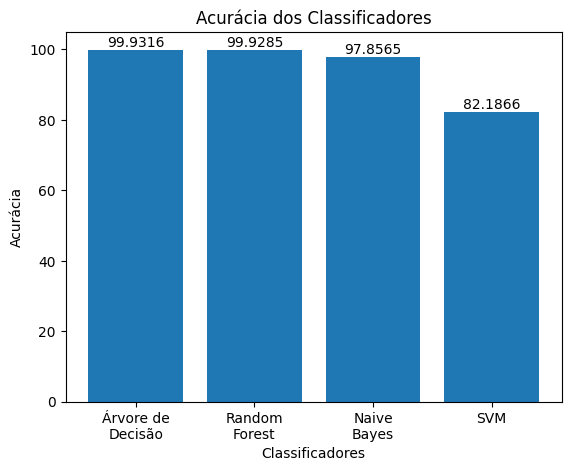

In [34]:
classificadores = dic.keys()
acc = dic.values()

fig, ax = plt.subplots()
bar_container = ax.bar(classificadores, acc)
#ax.set(ylabel='Acurácia', xlabel='Classificadores', title='Acurácia dos Classificadores', ylim=(0, 1.1))
ax.set(ylabel='Acurácia', xlabel='Classificadores', title='Acurácia dos Classificadores')
ax.bar_label(bar_container, fmt='{:,.4f}')

In [35]:
# Contabiliza o tempo de execução do algoritmo
tempo_total = (time.time() - start_time)
print(f'--- Tempo de execução: {tempo_total:.2f} segundos ---')

--- Tempo de execução: 4495.41 segundos ---


In [36]:
# Stop Spark session
spark.stop()